### Problem Statement

Help an Insurance company to build a model to predit the propensity to pay renewal premium and build an incentive pan for its agents to maximise the net revenew.


Available information inclueds past transactions from the policy holders along with their demographics. The client has provided aggregated historical transactional data like number of premiums delayed by 3/ 6/ 12 months across all the products, number of premiums paid, customer sourcing channel and customer demographics like age, monthly income and area type.


In addition to the information above, the client has provided the following relationships:

Expected effort in hours put in by an agent for incentives provided; and
Expected increase in chances of renewal, given the effort from the agent.
 

Given the information, the client wants you to predict the propensity of renewal collection and create an incentive plan for agents (at policy level) to maximise the net revenues from these policies.

#### Load modules

In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
sns.set(style='white', context='notebook', palette='deep')

import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import svm
from xgboost.sklearn import XGBClassifier
import lightgbm as lgb

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from imblearn.over_sampling import SMOTE
from sklearn.utils import resample

#### Load data

In [51]:
train = pd.read_csv('train_ZoGVYWq.csv')
test = pd.read_csv('test_66516Ee.csv')
combine = pd.concat([train.drop('renewal',1),test])

### Initial Exploration

In [4]:
train.head(8)

,id,perc_premium_paid_by_cash_credit,age_in_days,Income,Count_3-6_months_late,Count_6-12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,sourcing_channel,residence_area_type,premium,renewal
0,110936,0.429,12058,355060,0.0,0.0,0.0,99.02,13,C,Urban,3300,1
1,41492,0.010,21546,315150,0.0,0.0,0.0,99.89,21,A,Urban,18000,1
2,31300,0.917,17531,84140,2.0,3.0,1.0,98.69,7,C,Rural,3300,0
3,19415,0.049,15341,250510,0.0,0.0,0.0,99.57,9,A,Urban,9600,1
4,99379,0.052,31400,198680,0.0,0.0,0.0,99.87,12,B,Urban,9600,1
5,59951,0.540,17527,282080,2.0,0.0,0.0,99.18,9,B,Rural,22200,1
6,54031,1.000,24829,118400,0.0,0.0,0.0,99.05,11,B,Urban,7500,1
7,94290,1.000,21911,180240,1.0,6.0,4.0,99.33,3,A,Urban,9600,0


1. id is the Unique ID of the policy.
2. perc_premimum_paid_by_cash_credit is the percentage of premium amount paid by cash or credit card. I assume the rest of payment method is by cheque?
3. age_in_days is the age in days of policy holder
4. Income is the monthly income of policy holder
5. Count_3-6_months_late is number of premiums late by 3 to 6 months. This is an ordinal integer feature.
6. Count_6-12_months_late is number of premiums late by 6 to 12 months. This is an ordinal integer feature.
7. Count_more_than_12_months_late is number of premiums late by more than a year. This is an ordinal integer feature.
8. application_underwriting_score is the Underwriting Score of the applicant at the time of application. It must be higher or equal to 90.
9. no_of_premiums_paid is the total premiums paid on time till now. This is an ordinal integer feature.
10. sourcing_channel is the sourcing channel for application. This is a categorical character feature
11. residence_area_type is area type of residence. This is a categorical string feature
12. premium is the monthly premium amount
13. renewal indicates whether the policy renewed (1) or not (0)

In summary we have 4 floating point features, 1 integer variables, 4 ordinal integer features, 2 categorical text features except id and renewal.


In [6]:
train.describe()

,id,perc_premium_paid_by_cash_credit,age_in_days,Income,Count_3-6_months_late,Count_6-12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,premium,renewal
count,79853.000000,79853.000000,79853.000000,7.985300e+04,79756.000000,79756.000000,79756.000000,76879.000000,79853.000000,79853.000000,79853.000000
mean,57167.166368,0.314288,18846.696906,2.088472e+05,0.248671,0.078188,0.060008,99.067291,10.863887,10924.507533,0.937410
std,32928.970160,0.334915,5208.719136,4.965826e+05,0.691468,0.436507,0.312023,0.739799,5.170687,9401.676542,0.242226
min,2.000000,0.000000,7670.000000,2.403000e+04,0.000000,0.000000,0.000000,91.900000,2.000000,1200.000000,0.000000
25%,28640.000000,0.034000,14974.000000,1.080100e+05,0.000000,0.000000,0.000000,98.810000,7.000000,5400.000000,1.000000
50%,57262.000000,0.167000,18625.000000,1.665600e+05,0.000000,0.000000,0.000000,99.210000,10.000000,7500.000000,1.000000
75%,85632.000000,0.538000,22636.000000,2.520900e+05,0.000000,0.000000,0.000000,99.540000,14.000000,13800.000000,1.000000
max,114076.000000,1.000000,37602.000000,9.026260e+07,13.000000,17.000000,11.000000,99.890000,60.000000,60000.000000,1.000000


#### Missing values

In [7]:
print(train.isnull().sum())
print(test.info())

id                                     0
perc_premium_paid_by_cash_credit       0
age_in_days                            0
Income                                 0
Count_3-6_months_late                 97
Count_6-12_months_late                97
Count_more_than_12_months_late        97
application_underwriting_score      2974
no_of_premiums_paid                    0
sourcing_channel                       0
residence_area_type                    0
premium                                0
renewal                                0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34224 entries, 0 to 34223
Data columns (total 12 columns):
id                                  34224 non-null int64
perc_premium_paid_by_cash_credit    34224 non-null float64
age_in_days                         34224 non-null int64
Income                              34224 non-null int64
Count_3-6_months_late               34193 non-null float64
Count_6-12_months_late              34193 non-null float

There are some missing data in late payment record and underwriting score.

In [3]:
renew = train[train['renewal']==1]
norenew = train[train['renewal']==0]
renew_col = 'blue'
norenew_col = 'red'

print("Renewed: %i (%.1f percent), Not Renewed: %i (%.1f percent), Total: %i"\
      %(len(renew), 1.*len(renew)/len(train)*100.0,\
        len(norenew), 1.*len(norenew)/len(train)*100.0, len(train)))

Renewed: 74855 (93.7 percent), Not Renewed: 4998 (6.3 percent), Total: 79853


In our training data set about 93.7% of the policies got renewed.
Let's go through the features one by one to see what we find. Here we will see how the distributions of renewals and non-renewals compare. 

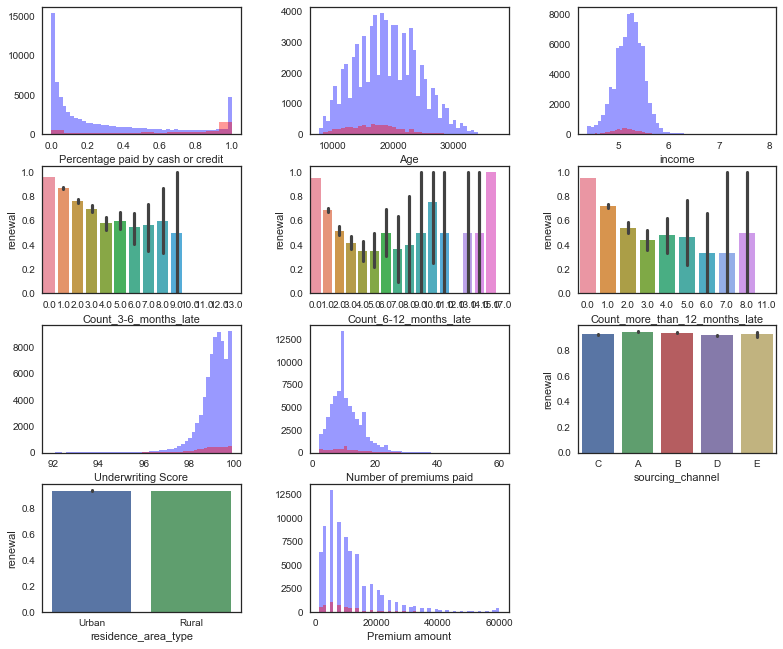

In [22]:
warnings.filterwarnings(action="ignore")
plt.figure(figsize=[12,10])
plt.subplot(431)
sns.distplot(renew['perc_premium_paid_by_cash_credit'].dropna().values, kde=False, color=renew_col)
sns.distplot(norenew['perc_premium_paid_by_cash_credit'].dropna().values, kde=False, color=norenew_col,
             axlabel='Percentage paid by cash or credit')
plt.subplot(432)
sns.distplot(renew['age_in_days'].dropna().values, kde=False, color=renew_col)
sns.distplot(norenew['age_in_days'].dropna().values, kde=False, color=norenew_col,
            axlabel='Age')
plt.subplot(433)
sns.distplot(np.log10(renew['Income'].dropna().values+1), kde=False, color=renew_col)
sns.distplot(np.log10(norenew['Income'].dropna().values+1), kde=False, color=norenew_col,
            axlabel='income')
plt.subplot(434)
sns.barplot('Count_3-6_months_late', 'renewal', data=train)
plt.subplot(435)
sns.barplot('Count_6-12_months_late', 'renewal', data=train)
plt.subplot(436)
sns.barplot('Count_more_than_12_months_late', 'renewal', data=train)
plt.subplot(437)
sns.distplot(renew['application_underwriting_score'].dropna().values, kde=False, color=renew_col)
sns.distplot(norenew['application_underwriting_score'].dropna().values, kde=False, color=norenew_col,
             axlabel='Underwriting Score')
plt.subplot(438)
sns.distplot(renew['no_of_premiums_paid'].dropna().values, kde=False, color=renew_col)
sns.distplot(norenew['no_of_premiums_paid'].dropna().values, kde=False, color=norenew_col,
             axlabel='Number of premiums paid')
plt.subplot(439)
sns.barplot('sourcing_channel', 'renewal', data=train)
plt.subplot(4,3,10)
sns.barplot('residence_area_type', 'renewal', data=train) 
plt.subplot(4,3,11)
sns.distplot(renew['premium'].dropna().values, kde=False, color=renew_col)
sns.distplot(norenew['premium'].dropna().values, kde=False, color=norenew_col,
             axlabel='Premium amount')
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)


**We learn**
1. sourcing_channel and residence_area_type do not affect renewal.
2. count of late payment: less late payment indicates more likelihood to renew.
3. person who renewed are less likely to pay by cash or credit card, compared with those who didnt renew.
4. person who didnot renewed seemed to be younger than those who renewed.


### Relations between features


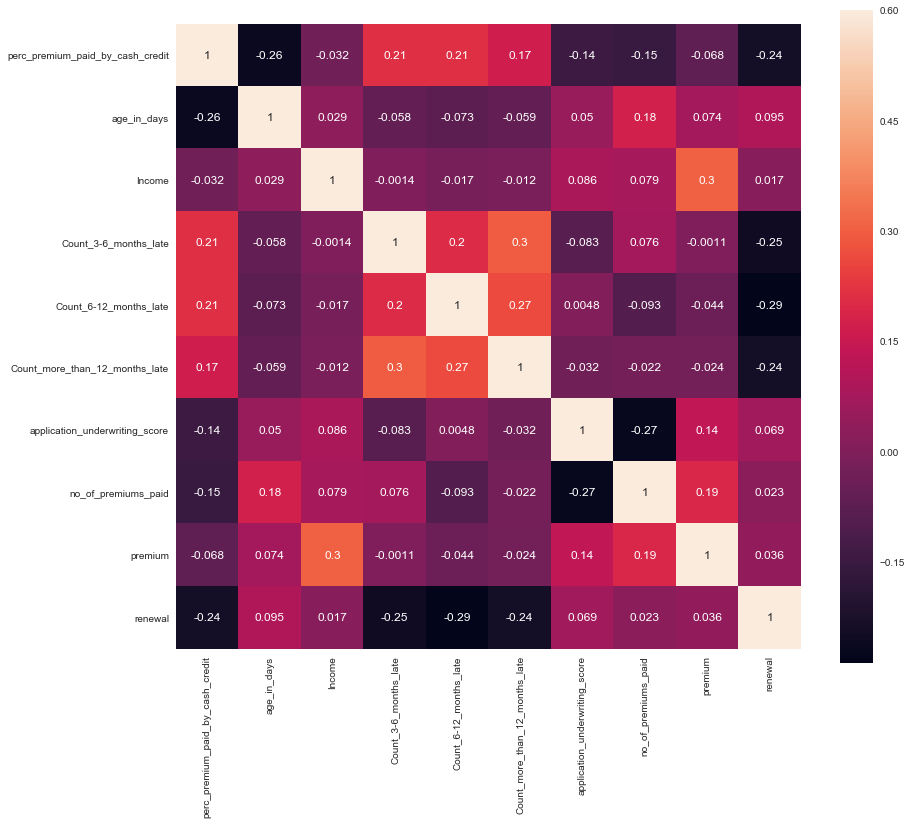

In [23]:
plt.figure(figsize=(14,12))
foo = sns.heatmap(train.drop('id',axis=1).corr(), vmax=0.6, square=True, annot=True)

## Feature Engineering


late_pay_group is calcuated based on count_late_payment


|count_late_payment | late_pay_group|
| ----------------- |:-------------:|
|0                  | 1             |
|1                  | 2             |
|2-6                | 3             |
|7-11               | 4             |
|12 and above       | 5             |

In [52]:
renewal = train['renewal']

combine['underwriting_known'] = combine['application_underwriting_score'].isnull()==False
combine['count_late_payment'] = combine['Count_3-6_months_late'] + combine['Count_6-12_months_late'] + combine['Count_more_than_12_months_late']
combine['late_pay_group'] = np.where(combine['count_late_payment']>=12,5,4)
combine['late_pay_group'] = np.where(combine['count_late_payment']<=6,3,combine['late_pay_group'])
combine['late_pay_group'] = np.where(combine['count_late_payment']==1,2,combine['late_pay_group'])
combine['late_pay_group'] = np.where(combine['count_late_payment']==0,1,combine['late_pay_group'])
combine['no_late_payment'] = combine['count_late_payment'] == 0
combine['late_pay_known'] = combine['count_late_payment'].isnull()==False
combine['amount_paid'] = combine['no_of_premiums_paid'] * combine['premium']
combine['pre_inc_ratio'] = combine['premium'] / combine['Income']
combine['age_in_years'] = combine['age_in_days'] / 365
combine.drop(['age_in_days'],axis=1,inplace=True)

test = combine.iloc[len(train):]
train = combine.iloc[:len(train)]
train['renewal'] = renewal

renew = train[train['renewal']==1]
norenew = train[train['renewal']==0]

Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x000001FE150D2A58>>
Traceback (most recent call last):
  File "C:\Users\admin\Anaconda3\lib\site-packages\xgboost\core.py", line 366, in __del__
    if self.handle is not None:
AttributeError: 'DMatrix' object has no attribute 'handle'


renewal                0      1
underwriting_known             
False                200   2774
True                4798  72081


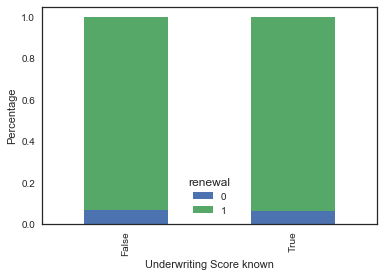

In [53]:
underwriting = pd.crosstab(train['underwriting_known'], train['renewal'])
print(underwriting)
dummy = underwriting.div(underwriting.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
dummy = plt.xlabel('Underwriting Score known')
dummy = plt.ylabel('Percentage')

renewal             0      1
no_late_payment             
False            3197  13108
True             1801  61747


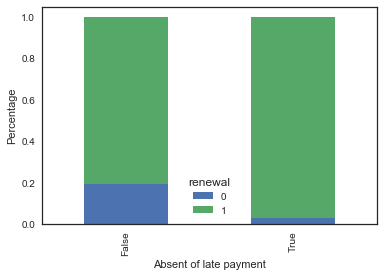

In [54]:
late_pay = pd.crosstab(train['no_late_payment'], train['renewal'])
print(late_pay)
dummy = late_pay.div(late_pay.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
dummy = plt.xlabel('Absent of late payment')
dummy = plt.ylabel('Percentage')

The late_pay_group is orinal numeric feature computed as below:
late_pay_group  count_late_pay
1               0
2               1
3               2,3,4,5,6
4               7,8,9,10,11
5               12 and above

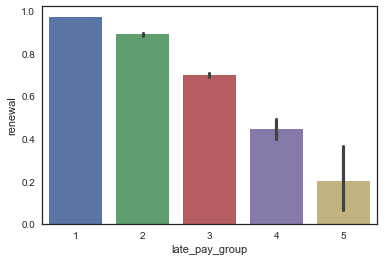

In [55]:
sns.barplot('late_pay_group', 'renewal', data=train)

renewal            0      1
late_pay_group             
1               1801  61747
2               1051   8546
3               1878   4360
4                244    196
5                 24      6


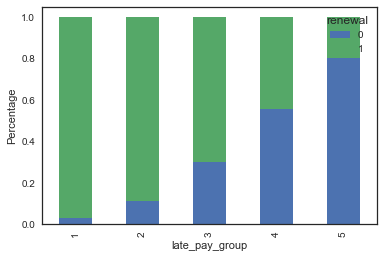

In [56]:
tab = pd.crosstab(train['late_pay_group'], train['renewal'])
print(tab)
dummy = tab.div(tab.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
dummy = plt.xlabel('late_pay_group')
dummy = plt.ylabel('Percentage')

renewal            0      1
late_pay_known             
False             60     37
True            4938  74818


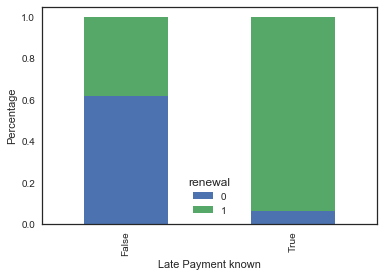

In [57]:
tab = pd.crosstab(train['late_pay_known'], train['renewal'])
print(tab)
dummy = tab.div(tab.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
dummy = plt.xlabel('Late Payment known')
dummy = plt.ylabel('Percentage')

## Preparing for modeling

convert categorical string variables into number

In [58]:
combine = pd.concat([train.drop('renewal',1),test])
renewal = train['renewal']

cat_cols = ['sourcing_channel', 'residence_area_type']

for cat_col in cat_cols:
    if cat_col == 'sourcing_channel':
        combine[cat_col] = combine[cat_col].astype('category')
        combine[cat_col].cat.categories = [0,1,2,3,4]
        combine[cat_col] = combine[cat_col].astype('int')
    else:
        combine[cat_col] = combine[cat_col].astype('category')
        combine[cat_col].cat.categories = [0,1]
        combine[cat_col] = combine[cat_col].astype('int')

combine.loc[:,["residence_area_type","sourcing_channel"]].head()

,residence_area_type,sourcing_channel
0,1,2
1,1,0
2,0,2
3,1,0
4,1,1


#### Imputing missing values with K-Nearest Neighbors

In [62]:
na_drop_cols = ['Count_3-6_months_late',
                'Count_6-12_months_late', 
                'Count_more_than_12_months_late']
combine = combine.dropna(subset=na_drop_cols)

test = combine.iloc[len(train):]
train = combine.iloc[:len(train)]
train['renewal'] = renewal

In [63]:
Y_col = 'application_underwriting_score'

X_cols = ['perc_premium_paid_by_cash_credit',
          'age_in_years',
          'Income',
          'Count_3-6_months_late',
          'Count_6-12_months_late',
          'Count_more_than_12_months_late',
          'no_of_premiums_paid',
          'premium',
          'sourcing_channel',
          'residence_area_type']

ALL_nan_idx = combine[Y_col].isna().nonzero()[0]
ALL_nan_TF = combine[Y_col].isna()
    
neigh = KNeighborsRegressor(n_neighbors=5, weights='distance', algorithm='brute',  metric='seuclidean')
neigh.fit(combine[X_cols][~ALL_nan_TF], combine[Y_col][~ALL_nan_TF]) 
    
   
    # For training dataset
nan_idx = train[Y_col].isna().nonzero()[0]
nan_TF = train[Y_col].isna()
    
for X_idx in nan_idx:
        #print(np.array(trn_dum_X[X_cols].iloc[X_idx])
    y = neigh.predict(train[X_cols].iloc[X_idx].values.reshape(1,-1))
    train[Y_col].iloc[X_idx] = y[0]
        #print(X_idx, y, trn_dum_imp_X[Y_col].iloc[X_idx])
    
    # For test dataset
nan_idx = test[Y_col].isna().nonzero()[0]
nan_TF = test[Y_col].isna()    
    
for X_idx in nan_idx:
        #print(np.array(tst_dum_X[X_cols].iloc[X_idx])
    y = neigh.predict(test[X_cols].iloc[X_idx].values.reshape(1,-1))
    test[Y_col].iloc[X_idx] = y[0]

In [64]:
train.columns

Index(['id', 'perc_premium_paid_by_cash_credit', 'Income',
       'Count_3-6_months_late', 'Count_6-12_months_late',
       'Count_more_than_12_months_late', 'application_underwriting_score',
       'no_of_premiums_paid', 'sourcing_channel', 'residence_area_type',
       'premium', 'underwriting_known', 'count_late_payment', 'late_pay_group',
       'no_late_payment', 'late_pay_known', 'amount_paid', 'pre_inc_ratio',
       'age_in_years', 'renewal'],
      dtype='object')

#### Standardize continuous variables

In [65]:
cols_for_std = ['Income', 'Count_3-6_months_late', 'Count_6-12_months_late',
                'Count_more_than_12_months_late', 'application_underwriting_score',
                'no_of_premiums_paid', 'premium', 
                'count_late_payment', 'amount_paid', 'age_in_years']

scaler = preprocessing.StandardScaler().fit(train[cols_for_std])
train[cols_for_std] = scaler.transform(train[cols_for_std])
test[cols_for_std] = scaler.transform(test[cols_for_std])

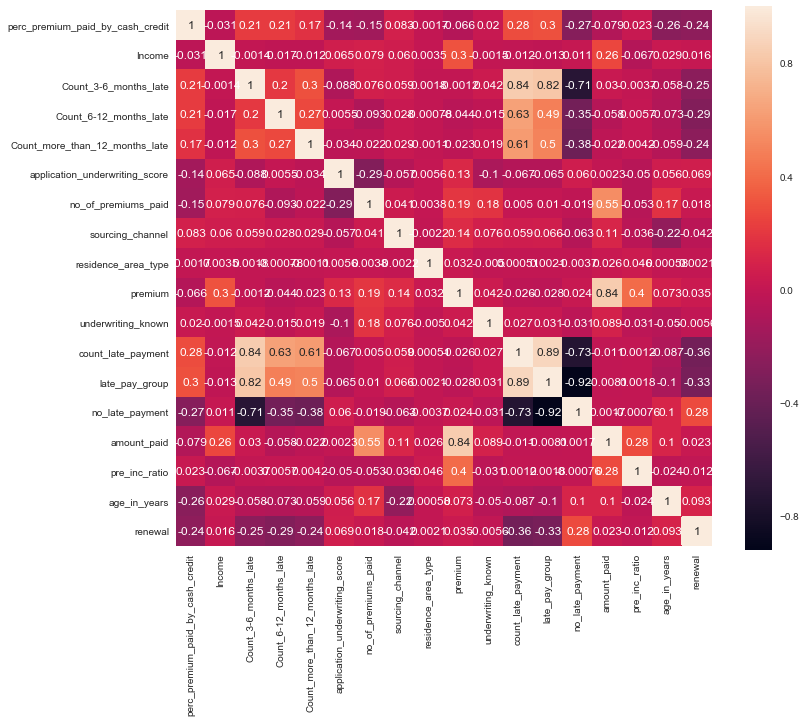

In [71]:
ax = plt.subplots( figsize =( 12 , 10 ) )
foo = sns.heatmap(train.drop('id',axis=1).corr(), vmax=1.0, square=True, annot=True)

## Modeling

Let's summarise briefly what we found in our data exploration:

number of late payment and percentage of cash/credit card payment are the main factors


#### Splitting the train sample into two sub-samples: training and testing
This is best practice for evaluating the performance of our models, which should not be tested on the same data they are trained on. This avoids overfitting.


In [72]:
training, testing = train_test_split(train, test_size=0.2, random_state=0)
print("Total sample size = %i; training sample size = %i, testing sample size = %i"\
     %(train.shape[0],training.shape[0],testing.shape[0]))

Total sample size = 79853; training sample size = 63882, testing sample size = 15971


Use SMOT to handle imbalanced data

In [73]:
def model_prep(df,cols):
    
    tcols = np.append(['renewal'],cols)

    df = df.loc[:,tcols].dropna()
    X = df.loc[:,cols]
    y = np.ravel(df.loc[:,['renewal']])

    return X,y

In [74]:
def get_balanced_train_data(df,cols):
    sm = SMOTE(random_state=42)
    X_train, y_train = model_prep(df, cols)
    X_train_smote, y_train_smote = sm.fit_sample(X_train,y_train)
    type(X_train_smote), type(y_train_smote)

    X_train_smote = pd.DataFrame(X_train_smote, columns= X_train.columns)
    y_train_smote= pd.Series(y_train_smote)
    
    return (X_train_smote, y_train_smote)

In [75]:
train.columns

Index(['id', 'perc_premium_paid_by_cash_credit', 'Income',
       'Count_3-6_months_late', 'Count_6-12_months_late',
       'Count_more_than_12_months_late', 'application_underwriting_score',
       'no_of_premiums_paid', 'sourcing_channel', 'residence_area_type',
       'premium', 'underwriting_known', 'count_late_payment', 'late_pay_group',
       'no_late_payment', 'amount_paid', 'pre_inc_ratio', 'age_in_years',
       'renewal'],
      dtype='object')

In [76]:
cols = ['perc_premium_paid_by_cash_credit', 'Income',
       'Count_3-6_months_late', 'Count_6-12_months_late',
       'Count_more_than_12_months_late', 'application_underwriting_score',
       'no_of_premiums_paid', 'sourcing_channel', 'residence_area_type',
       'premium', 'count_late_payment', 'amount_paid', 'pre_inc_ratio', 'age_in_years']
X_train, y_train = model_prep(training, cols)
print(X_train.shape,y_train.shape)
X_train_res, y_train_res = get_balanced_train_data(training,cols)
print(X_train_res.shape, y_train_res.shape)
X_test, y_test = model_prep(testing, cols)
X_all, y_all = model_prep(train,cols)

(63882, 14) (63882,)
(119808, 14) (119808,)


In [77]:
def evaluate_model_auc(model, X_test_parameter, y_test_parameter):
    ## The predictions
    y_pred = model.predict(X_test_parameter)
    ## Calculate the auc score
    auc_score = roc_auc_score(y_test_parameter,y_pred)
    ## Returns the score to the model
    return auc_score

### Logistic Regression

In [78]:
clf_log = LogisticRegression(class_weight='balanced')
clf_log = clf_log.fit(X_train,y_train)
evaluate_model_auc(clf_log, X_test, y_test)

0.77237571381562764

### K Nearest Neighbors

In [20]:
clf_knn = KNeighborsClassifier(n_neighbors=10, weights='distance')
clf_knn = clf_knn.fit(X_train_res,y_train_res)
evaluate_model_auc(clf_knn, X_test, y_test)  

0.69078050872344843

### Support Vector Machine:

In [21]:
clf_svm = svm.SVC()
clf_svm.fit(X_train_res,y_train_res)
evaluate_model_auc(clf_svm, X_test, y_test)

0.75214944387854099

### Random Forest

In [24]:
clf_rf = RandomForestClassifier(
    n_estimators=1000, \
    max_depth=None, \
    min_samples_split=10, \
    class_weight="balanced", \
    #min_weight_fraction_leaf=0.02 \
    )
clf_rf = clf_rf.fit(X_train,y_train)
evaluate_model_auc(clf_rf, X_test, y_test)

0.65537828915257679

#### Hyperparameter optimization for Random Forest

In [79]:
param = {'n_estimators':[500, 600, 700, 800, 900, 1000]}

def clf_RF(trn_X, trn_Y, param):
    clf_RF = RandomForestClassifier()
    clf = GridSearchCV(clf_RF, param, n_jobs=8, cv=10, scoring='roc_auc')
    clf.fit(trn_X, trn_Y)
    return clf

clf_model = clf_RF(X_all, y_all, param)
print(clf_model.best_score_)


0.827332116829


### Gradient Boosting

In [80]:
def clf_GBT(trn_X, trn_Y, param):
    clf_GBT = GradientBoostingClassifier()
    clf = GridSearchCV(clf_GBT, param, n_jobs=8, cv=10, scoring='roc_auc')
    clf.fit(trn_X, trn_Y)
    return clf 

In [81]:
param = {'n_estimators':[50, 100, 150, 200, 300, 400, 500], 
         'max_depth':[2, 3, 4, 5, 6]}

clf_gb = clf_GBT(X_all, y_all, param)
print(clf_gb.best_score_)

0.840655699464


### LightGBM

Training until validation scores don't improve for 200 rounds.
[20]	valid_0's auc: 0.85282
[40]	valid_0's auc: 0.854021
[60]	valid_0's auc: 0.855133
[80]	valid_0's auc: 0.85536
[100]	valid_0's auc: 0.855853
[120]	valid_0's auc: 0.855887
[140]	valid_0's auc: 0.856338
[160]	valid_0's auc: 0.856496
[180]	valid_0's auc: 0.856401
[200]	valid_0's auc: 0.856753
[220]	valid_0's auc: 0.856796
[240]	valid_0's auc: 0.856762
[260]	valid_0's auc: 0.856772
[280]	valid_0's auc: 0.856511
[300]	valid_0's auc: 0.856353
[320]	valid_0's auc: 0.856397
[340]	valid_0's auc: 0.856549
[360]	valid_0's auc: 0.856741
[380]	valid_0's auc: 0.85655
[400]	valid_0's auc: 0.856453
[420]	valid_0's auc: 0.856316
Early stopping, best iteration is:
[238]	valid_0's auc: 0.856859
Plot feature importances...


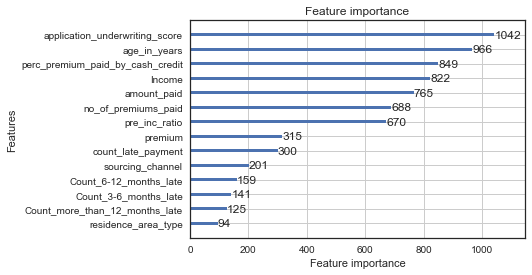

In [82]:
params = {
    'learning_rate': 0.02, 
    'boosting': 'gbdt', 
    'objective': 'binary', 
    'metric': 'auc', 
    'is_training_metric': False, 
    'scale_pos_weight': 0.5,
    'max_depth': 8,  
    'min_child_samples': 100,  
    'max_bin': 100,  
    'subsample': 0.7,  
    'subsample_freq': 1,  
    'colsample_bytree': 0.7,
    'seed': 0
}

fit_model = lgb.train(params, train_set=lgb.Dataset(X_train, label=y_train), num_boost_round=2000,
            valid_sets=lgb.Dataset(X_test, label=y_test), verbose_eval=20, early_stopping_rounds=200)

print('Plot feature importances...')
ax = lgb.plot_importance(fit_model, max_num_features=20)
plt.show()

### eXtreme Gradient Boosting - XGBoost:

In [83]:
def modelfit(alg, dtrain, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['renewal'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print ("\nModel Report")
    #print ("Accuracy : %.4g" % accuracy_score(dtrain['renewal'].values, dtrain_predictions))
    print ("AUC Score (Train): %f" % roc_auc_score(dtrain['renewal'], dtrain_predprob))
                    
    
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')


Model Report
AUC Score (Train): 0.864087


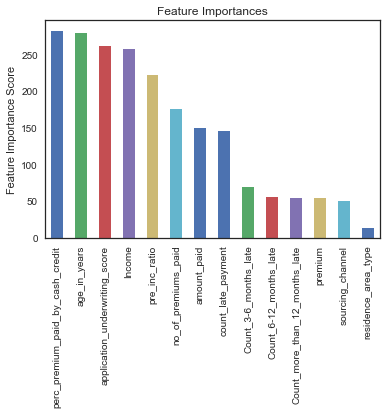

In [84]:
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1, train, cols)

In [85]:
param_test1 = {'max_depth':list(range(3,10,2)), 'min_child_weight':list(range(1,6,2))}
gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=140, max_depth=5,
                                                  min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                                  objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
                        param_grid = param_test1, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
gsearch1.fit(X_all,y_all)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.84090, std: 0.00702, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.84063, std: 0.00674, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.84085, std: 0.00691, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.83969, std: 0.00815, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.83939, std: 0.00818, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.83977, std: 0.00750, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.83445, std: 0.00802, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: 0.83482, std: 0.00824, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: 0.83458, std: 0.00745, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: 0.82709, std: 0.00698, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: 0.82761, std: 0.00659, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: 0.82992, std: 0.00756, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 3, 'min_child_weight': 1

In [95]:
test.head()

,id,perc_premium_paid_by_cash_credit,Income,Count_3-6_months_late,Count_6-12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,sourcing_channel,residence_area_type,premium,underwriting_known,count_late_payment,late_pay_group,no_late_payment,late_pay_known,amount_paid,pre_inc_ratio,age_in_years,renewal
97,82176,0.544,0.104289,-0.359421,-0.179308,-0.192323,0.378746,-0.750361,3,1,-0.141526,True,-0.370596,1,True,True,-0.402303,0.036817,-0.814506,0.038439
98,53475,0.780,-0.029409,1.083921,2.111988,3.009178,-0.451609,0.411351,0,1,-0.141526,True,2.499651,3,False,True,-0.022069,0.049393,0.587232,0.400946
99,88108,0.013,0.183593,-0.359421,-0.179308,-0.192323,1.100202,-0.750361,0,1,0.752002,True,-0.370596,1,True,True,-0.014148,0.059974,1.428121,0.005831
100,65166,0.073,-0.340343,-0.359421,-0.179308,-0.192323,-3.187696,-0.750361,2,1,-1.035053,True,-0.370596,1,True,True,-0.790459,0.030030,0.166980,0.024297
101,65378,0.903,-0.215204,-0.359421,-0.179308,-0.192323,0.596544,-1.137599,0,1,-0.588289,True,-0.370596,1,True,True,-0.667675,0.052889,2.339308,0.036762


In [104]:
preds_renewals = xgb1.predict(test[cols])
pred_prob_renewals = xgb1.predict_proba(test[cols])
test['renewal'] = preds_renewals

submission = test[['id','renewal','premium']]
submission.head()


,id,renewal,premium
97,82176,1,-0.141526
98,53475,1,-0.141526
99,88108,1,0.752002
100,65166,1,-1.035053
101,65378,1,-0.588289


## Calculate incentives

Equation for the effort-incentives curve: Y = 10*(1-exp(-X/400))

Equation for the % improvement in renewal prob vs effort curve: Y = 20*(1-exp(-X/5))



In [ ]:
'''
Revenue (R) = [ pbenchmark + (0.20 (1 - exp(-2 (1 - exp(-incentive/400))))) * pbenchmark ] * premium -  incentive
Revenue (R) will maximize when dR/di is zero where i is incentive
since d/dx [ 0.20 (1 - exp(-2 (1 - exp(-x/400)))) ] = 1/1000 e^(-x/400 + 2 e^(-x/400) - 2)

so dR/di = (premium * pbenchmark) * 1/1000 e^[-i/400 + 2 e^(-i/400) - 2] - 1 
solve following equation to get optimal incentive value
        (premium * pbenchmark) * 1/1000 e^[-i/400 + 2 e^(-i/400) - 2] - 1 = 0
        i.e -i/400 + 2 e^(-i/400) -2 - log (1000 /(premium * pbenchmark) = 0
'''

In [ ]:
from sympy.solvers import solve
from sympy import Symbol, exp
def calculate_incentive(y):
    try:
        Premium = y[0]
        prob = y[1]
        x = Symbol('x')
        l = solve(-x/400 + 2 * exp(-x/400) - 2 - np.log(1000/(Premium * prob)), x)
        return float(l[0])
    except:
        return 0.0
    
import multiprocessing
from multiprocessing import Pool
cores = multiprocessing.cpu_count()

def parallelize_dataframe(df, func):
    df_split = np.array_split(df, cores)
    pool = Pool(cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

def return_incentive(df):
    df['incentives'] = df[['premium', 'renewal']].apply(lambda x : calculate_incentive(x), axis = 1)
    return df


final_df = parallelize_dataframe(submission, return_incentive)
print(final_df.head())

In [17]:
from scipy.optimize import fmin

def impr_rev(x, *args):
    premium = args[0]
    return x-0.2*(1-np.exp(-10*(1-np.exp(-x/400))/5))*premium


In [18]:
inc = []
for i in premium:
    res = fmin(func=impr_rev, x0=0, args=(i,),disp=False)
    inc.append(res[0])
    

In [19]:
inc

[183.37968750000022,
 446.10131250000052,
 446.10131250000052,
 275.91037500000039,
 399.42912500000045,
 446.10131250000052,
 183.37968750000022,
 275.91037500000039,
 486.77562500000056,
 684.48056250000081,
 585.41900000000078,
 24.812125000000034,
 446.10131250000052,
 24.812125000000034,
 24.812125000000034,
 555.60556250000059,
 344.26593750000052,
 705.51543750000087,
 446.10131250000052,
 183.37968750000022,
 486.77562500000056,
 446.10131250000052,
 286.77887500000043,
 399.42912500000045,
 486.77562500000056,
 446.10131250000052,
 779.41150000000084,
 344.26593750000052,
 24.812125000000034,
 399.42912500000045,
 275.91037500000039,
 344.26593750000052,
 344.26593750000052,
 275.91037500000039,
 183.37968750000022,
 446.10131250000052,
 585.41900000000078,
 24.812125000000034,
 24.812125000000034,
 446.10131250000052,
 275.91037500000039,
 555.60556250000059,
 183.37968750000022,
 399.42912500000045,
 555.60556250000059,
 183.37968750000022,
 344.26593750000052,
 446.10131250

In [20]:
submit = pd.DataFrame({'id' : test.loc[:,'id'],
                       'renewal': renew_pred,
                       'incentives': inc})
cols = ['id','renewal','incentives']
submit = submit[cols]
submit.head()

,id,renewal,incentives
0,649,1,183.379688
1,81136,1,446.101313
2,70762,0,446.101313
3,53935,1,275.910375
4,15476,1,399.429125


In [21]:
submit.to_csv("submit.csv", index=False)